# Creating an Email Spam Filter using Naive Bayes

In this project, we are going to create a spam filter for SMS messages that classifies the messages as either spam or ham (non-spam). To be effective, the spam filter must be successful at classifying messages at least 80% of the time. 

First, the Naive Bayes algorithm will have to be trained on a dataset from The UCI Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/sms+spam+collection) containing 5,572 SMS messages that have already been classified by humans. 

## Summary of Results

The Naive Bayes algorithm used to classify messages as either ham or spam was 98.7% accurate when tested on the test data set that it had not seen before.

## Read in the data

In [1]:
import pandas as pd

#Use pd.read_csv to read in the tab delimited csv file containing SMS messages and their labels as either spam or ham
df = pd.read_csv('SMSSpamCollection', sep='\t', header=None, names=['Label','SMS'])

## Explore the data

In [2]:
df.head()

,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df.shape

(5572, 2)

In [4]:
#Calculate the percentage of ham in the dataset
ham_perc = df['Label'][df['Label']=='ham'].count()/df['Label'].count()*100
ham_perc

86.59368269921033

In [5]:
#Calculate the percentage of spam in the dataset
spam_perc = 100 - ham_perc
spam_perc

13.406317300789667

The percentage of ham (87%) and spam (13%) in the dataset seems to be fairly representative since most messages people receive are ham. 

## Split the dataset into a training set and a test set

The Naive Bayes algorithm will be trained to classify messages as either ham or spam on 80% of the data. The Naive Bayes algorithm will then be tested on the remaining 20% of the data to determine how effective the algorithm is at classifying messages as ham or spam. 

In [6]:
#Randomize the dataset
df_rand = df.sample(frac=1, random_state=1)

In [7]:
#Create a training set from the dataset consisting of 80% of the messages
df_t = df_rand[0:4458].reset_index(drop=True)
df_t.shape

(4458, 2)

In [8]:
#Create a test set from the dataset consisting of 20% of the messages
df_test = df_rand[4458:].reset_index(drop=True)
df_test.shape

(1114, 2)

In [9]:
#Calculate the percentage of ham in the training set
df_t['Label'][df_t['Label']=='ham'].count()/df_t['Label'].count()

0.8654104979811574

In [10]:
#Calculate the percentage of ham in the test set
df_test['Label'][df_test['Label']=='ham'].count()/df_test['Label'].count()

0.8680430879712747

Both the training and the test set are representative of the total dataset since the percentage of ham messages is about the same (87%). 

## Clean the training set

In [11]:
#Remove all punctuation marks and lower case all word characters
df_t['SMS'] = df_t['SMS'].str.replace('\W',' ')
df_t['SMS'] = df_t['SMS'].str.lower()

In [12]:
#Length of the training set
len(df_t)

4458

## Create a list containing the entire vocabulary of the training set

In [13]:
#Create an empty list to store all of the unique words from the training set
vocabulary = []

In [14]:
#Split each message into a list of words
df_t['SMS'] = df_t['SMS'].str.split()

In [15]:
#For loop to add each word to the vocabulary list
#Set() creates a list containing only unique entries from the for loop vocabulary list
#The set of unique vocabulary entries is then converted back to a list
for lst in df_t['SMS']:
    for word in lst:
        vocabulary.append(word)
vocabulary = list(set(vocabulary))

In [16]:
#Length of the vocabulary list from the training set containing only unique entries
len(vocabulary)

7783

## Create a dataframe containing word counts for each SMS message

In [17]:
#Create a dictionary containing 0 for each of the messages withinn the training set
#This will be used to create a dataframe containing the word counts of each word in each message
word_counts_per_sms = {unique_word: [0] * len(df_t['SMS']) for unique_word in vocabulary}

In [18]:
#Loop through each SMS message and increase the count of a word by 1 in the word_counts_per_sms dictionary each time it occurs
for index, sms in enumerate(df_t['SMS']):
    for word in sms:
        word_counts_per_sms[word][index] += 1

In [19]:
#Convert the word_counts_per_sms to a dataframe
word_counts = pd.DataFrame(word_counts_per_sms)
word_counts.head()

,beautiful,sick,sth,katexxx,swing,tea,short,trauma,waqt,1131,...,gbp4,feelingood,laxinorficated,sweetest,kicks,meetins,kate,hugs,dane,euro2004
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We have now created a dataframe containing the particular word counts of each SMS message. Now we will combine this dataframe with the training set dataframe but need to make sure that both have the same number of rows. 

In [20]:
#Shape of the word counts dataframe
word_counts.shape

(4458, 7783)

In [21]:
#Shape of the training set
df_t.shape

(4458, 2)

In [22]:
#Combine the word_counts and training set dataframes, concatenating columns of each together
df_train = pd.concat([df_t, word_counts], axis=1)
df_train.head()

,Label,SMS,beautiful,sick,sth,katexxx,swing,tea,short,trauma,...,gbp4,feelingood,laxinorficated,sweetest,kicks,meetins,kate,hugs,dane,euro2004
0,ham,"[yep, by, the, pretty, sculpture]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[yes, princess, are, you, going, to, make, me,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,[havent],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,"[i, forgot, 2, ask, ü, all, smth, there, s, a,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
#Shape of the combined dataframe
df_train.shape

(4458, 7785)

## Naive Bayes Algorithm

We will use the following two equations to determine the probabilties that a message is spam or ham given the words that occur within the message. 

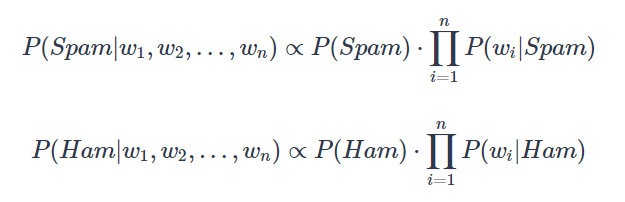

We will use the following two equations with Laplace smoothing (alpha = 1) to determine the probabilities that a word occurs given a message is spam or ham. These will then be used in the above equations.

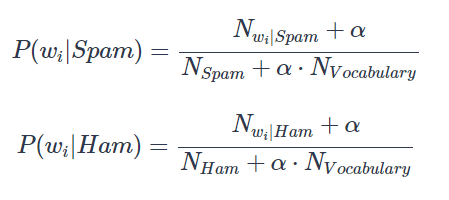

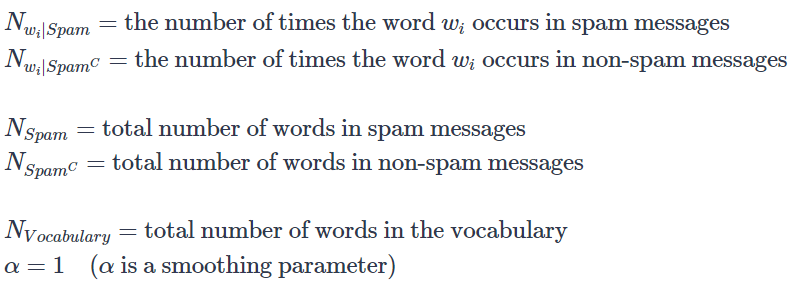

## Calculate the constants needed for the above equations

In [24]:
#Number of ham messages in the combined dataframe
ham_messages = df_train[df_train['Label']=='ham']
ham_messages.shape

(3858, 7785)

In [25]:
#Number of spam messages in the combined dataframe
spam_messages = df_train[df_train['Label']=='spam']
spam_messages.shape

(600, 7785)

In [26]:
#Percentage of ham messages in the combined dataframe
p_ham = len(ham_messages)/len(df_train)
p_ham

0.8654104979811574

In [27]:
#Percentage of spam messages in the combined dataframe
p_spam = len(spam_messages)/len(df_train)
p_spam

0.13458950201884254

In [28]:
#Verify that the sum of percentages of ham and spam equals 1
p_spam + p_ham

1.0

In [29]:
#Number of words in all spam messages
n_words_per_spam_message = spam_messages['SMS'].apply(len)
n_spam = n_words_per_spam_message.sum()
n_spam

15190

In [30]:
#Number of words in all ham messages
n_words_per_ham_message = ham_messages['SMS'].apply(len)
n_ham = n_words_per_ham_message.sum()
n_ham

57237

In [31]:
#Number of unique words in all messages
n_voc = len(vocabulary)
n_voc

7783

In [32]:
#Laplace smoothing factor
alpha = 1

In [33]:
#Create dictionaries to store the probabilities that a unique word occurs given a message is spam or ham
param_spam = {unique_word:0 for unique_word in vocabulary}
param_ham = {unique_word:0 for unique_word in vocabulary}

In [34]:
#Loop through each unique word in the vocabulary list and calculate the number of times it occurs in all spam messages
#Calculate the probabilites that a word occurs given a message is spam or ham
#Add the probabilties to the param_spam or param_ham dictionaries
for word in vocabulary: 
    n_word_given_spam = spam_messages[word].sum()
    p_word_given_spam = (n_word_given_spam + alpha)/(n_spam + alpha*n_voc)
    param_spam[word] = p_word_given_spam
    
    n_word_given_ham = ham_messages[word].sum()
    p_word_given_ham = (n_word_given_ham + alpha)/(n_ham + alpha*n_voc)
    param_ham[word] = p_word_given_ham

## Create a ham/spam classification function

In [35]:
#Import regular expressions
import re

#Create a function that takes in a message and outputs whether the message is ham or spam
def classify(message):
    
#Remove punctuation, make all characters lower case, and convert to a list of words
    message = re.sub('\W', ' ', message)
    message = message.lower()
    message = message.split()

    p_spam_given_message = p_spam
    p_ham_given_message = p_ham
    
#Loop through each word in the message and recalculate the probability that the message is spam or ham given the words within    
    for word in message: 
        if word in param_spam: 
            p_spam_given_message *= param_spam[word]
        if word in param_ham:
            p_ham_given_message *= param_ham[word]

#Print calculated probabilties
    print('P(Spam|message):', p_spam_given_message)
    print('P(Ham|message):', p_ham_given_message)

#Compare the two probabilities and print whether the message is ham, spam, or needs to be classified by humans   
    if p_ham_given_message > p_spam_given_message:
        print('Label: Ham')
    elif p_ham_given_message < p_spam_given_message:
        print('Label: Spam')
    else:
        print('Equal proabilities, have a human classify this!')

In [36]:
#Test the function on a message that is clearly spam
classify('WINNER!! This is the secret code to unlock the money: C3421.')

P(Spam|message): 1.3481290211300841e-25
P(Ham|message): 1.9368049028589875e-27
Label: Spam


In [37]:
#Test the function on a message that is clearly ham
classify("Sounds good, Tom, then see u there")

P(Spam|message): 2.4372375665888117e-25
P(Ham|message): 3.687530435009238e-21
Label: Ham


In [38]:
#Rewrite the classification function to return ham, spam, or needs human classification as opposed to printing
#This allows the function to be applied to the test set of data
def classify_test_set(message):

    message = re.sub('\W', ' ', message)
    message = message.lower()
    message = message.split()

    p_spam_given_message = p_spam
    p_ham_given_message = p_ham

    for word in message:
        if word in param_spam:
            p_spam_given_message *= param_spam[word]

        if word in param_ham:
            p_ham_given_message *= param_ham[word]

    if p_ham_given_message > p_spam_given_message:
        return 'ham'
    elif p_spam_given_message > p_ham_given_message:
        return 'spam'
    else:
        return 'needs human classification'

In [39]:
#Apply the classification function to the test set of data
df_test['predicted'] = df_test['SMS'].apply(classify_test_set)
df_test.head()

,Label,SMS,predicted
0,ham,Later i guess. I needa do mcat study too.,ham
1,ham,But i haf enuff space got like 4 mb...,ham
2,spam,Had your mobile 10 mths? Update to latest Oran...,spam
3,ham,All sounds good. Fingers . Makes it difficult ...,ham
4,ham,"All done, all handed in. Don't know if mega sh...",ham


In [40]:
#Determine the accuracy of the aglorithm
correct = 0
total = 1114
for row in df_test.iterrows():
    if row[1]['Label'] == row[1]['predicted']:
        correct += 1
accuracy = correct/total

print('Correct:', correct)
print('Incorrect:', total - correct)
print('Accuracy:', correct/total)

Correct: 1100
Incorrect: 14
Accuracy: 0.9874326750448833


The Naive Bayes algorithm was 98.7% accuratewhen classifying the messages from the test data set, which is considerably higher than the initial goal of having accurate classification of at least 80% of the messages as either ham or spam. 